# ACE Exploration: Peptide Feature Similarities Exploration

### Dhuvarakesh Karthikeyan and Jin Seok (Andy) Lee

In [1]:
#Import Dependencies

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import math
from sklearn.model_selection import train_test_split

import difflib
import Levenshtein as levenshtein
from collections import Counter
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#import mhcflurry
from transformers import BertModel, BertTokenizer
from transformers import AutoTokenizer, AutoModelForMaskedLM

In [2]:
torch.cuda.is_available()
# Set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

### Load in the Data

In [3]:
### For one of the sequence similarity experiments, we remove the following epitopes from the training data.

mage3_epitopes = [
"ESDPIVAQY",
"EVDPIGHLY",
"EVDPIGHVY",
"EVDPIRHYY",
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
]

In [4]:
### Get the raw data of paired TCR:pMHC Data
raw_df = pd.read_csv("../data/post_processing_all_data.csv")
data_df = raw_df[["CDR3b", "Epitope", 'Allele', 'Condition', 'Dataset.Origin']]
data_df = data_df[data_df['Dataset.Origin'] != 'MIRA']

### Filter out the SARS-Cov2 data
# Define a regular expression pattern to match flexible combinations of "Sars-cov2"
pattern = re.compile(r'sars[\W_]*cov[\W_]*[12]', re.IGNORECASE)
# Take out the SARS-Cov2 data
holdout_df = data_df[data_df['Condition'].str.contains(pattern, na=False)]
data_df = data_df[~data_df['Condition'].str.contains(pattern, na=False)]
data_df = data_df[~data_df['Condition'].str.contains('coronavirus', na=False)]
holdout_df = pd.concat([holdout_df, data_df[data_df['Condition'].str.contains('coronavirus', na=False)]])

### Filter out the MAGE3a data
data_df = data_df[~data_df['Epitope'].isin(mage3_epitopes)]
assert set(data_df['Epitope']).intersection(mage3_epitopes) == set()
holdout_df = pd.concat([holdout_df, data_df[data_df['Epitope'].isin(mage3_epitopes)]])

# Concatenate all of the different Conditions [Disease Contexts]
data_df = data_df.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
data_df['Dataset.Origin'] = [data_df['Dataset.Origin'][i][0] for i in range(len(data_df))]
holdout_df = holdout_df.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
data_df.sort_values(by=['CDR3b', 'Epitope'])

/tmp/ipykernel_26024/432117211.py:2: DtypeWarning: Columns (0,6,7,8,9,10,11,12,13,15,17,18,21,24) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv("../data/post_processing_all_data.csv")


,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,CAAADEEIGNQPQHF,ATDALMTGY,HLA-A*01:01,"[Hepatitis C virus, HCV]",IEDB
1,CAAAHLDSSNEQYF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
2,CAAALGGGANEQF,GILGFVFTL,HLA-A*02:01,[Influenza A virus],IEDB
3,CAAALGQSRTPGSCFF,GLCTLVAML,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
4,CAAALWTQHF,GILGFVFTL,HLA-A*02:01,[Influenza A virus],IEDB
...,...,...,...,...,...
66789,CYSYNEQFF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
66790,CYTF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
66791,CYTF,YVLDHLIVV,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
66792,CYVGQALYNEQFF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB


In [5]:
# Filter the numbers of CDR3b for counts over 1
cdr3b_counts = data_df['CDR3b'].value_counts()
cdr3b_counts = cdr3b_counts[cdr3b_counts > 1]
data_df2 = data_df[data_df['CDR3b'].isin(cdr3b_counts.index)]
data_df2.sort_values(by=['CDR3b', 'Epitope'])
data_df2.reset_index(inplace=True, drop=True)
data_df2

,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,CAAGEMFGLGETQYF,AVFDRKSDAK,HLA-A*11:01,[EBV],VDJdb
1,CAAGEMFGLGETQYF,KLGGALQAK,HLA-A*03:01,[CMV],VDJdb
2,CAAGGGGTEKLFF,GLCTLVAML,HLA-A*02:01,[EBV],VDJdb
3,CAAGGGGTEKLFF,IVTDFSVIK,HLA-A*11:01,"[EBV, EBV]",VDJdb
4,CAAGGGGTEKLFF,KLGGALQAK,HLA-A*03:01,"[CMV, CMV]",VDJdb
...,...,...,...,...,...
10508,CYGYTF,YVLDHLIVV,HLA-A*02:01,[Human herpesvirus 4 (Epstein Barr virus)],IEDB
10509,CYNEQFF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
10510,CYNEQFF,YVLDHLIVV,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB
10511,CYTF,GLCTLVAML,HLA-A*02:01,"[Human herpesvirus 4 (Epstein Barr virus), Hum...",IEDB


In [6]:
negative_injection = pd.read_csv('../data/negative_epitopes.csv')
negative_injection = negative_injection[['Epitope - Name', 'Epitope - Source Organism']]
negative_injection.columns = ['Epitope', 'Condition']
# Use the SARS pattern from the beginning
negative_injection = negative_injection[~negative_injection['Condition'].str.contains(pattern, na=False)]
negative_injection = negative_injection[~negative_injection['Condition'].str.contains('coronavirus', na=False)]
# Assign Arbitrary Allele and CDR3b
negative_injection['Allele'] = ['HLA-ALL3L3']* len(negative_injection)
negative_injection['CDR3b'] = ['AAAAAAAAAAAA']* len(negative_injection)
negative_injection['Dataset.Origin'] = ['Negative']* len(negative_injection)
# Filter for reasonable epitope length
negative_injection['Epitope_Length'] = [len(epi) for epi in negative_injection['Epitope']]
negative_injection = negative_injection[negative_injection['Epitope_Length'] <= 15]
negative_injection = negative_injection.drop(['Epitope_Length'], axis=1, inplace=False)
# Subset
negative_injection = negative_injection[['CDR3b', 'Epitope', 'Allele', 'Condition', 'Dataset.Origin']]
negatigve_injection = negative_injection.groupby(["CDR3b", "Epitope", "Allele"]).agg({'Condition': list, 'Dataset.Origin': list}).reset_index()
negative_injection = negative_injection[~negative_injection['Epitope'].isin(mage3_epitopes)]

negative_injection

,CDR3b,Epitope,Allele,Condition,Dataset.Origin
0,AAAAAAAAAAAA,AAAAAIFVI,HLA-ALL3L3,Homo sapiens,Negative
1,AAAAAAAAAAAA,AAAIFMTATPPGTAD,HLA-ALL3L3,dengue virus type 3,Negative
2,AAAAAAAAAAAA,AAALALHFL,HLA-ALL3L3,Human herpesvirus 5 strain AD169,Negative
3,AAAAAAAAAAAA,AAALALLASLILGT,HLA-ALL3L3,Human herpesvirus 4 strain B95-8,Negative
4,AAAAAAAAAAAA,AAASKVKANLLSVEE,HLA-ALL3L3,hepatitis C virus genotype 1a,Negative
...,...,...,...,...,...
30286,AAAAAAAAAAAA,WCGPTPSYNKRVF,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30287,AAAAAAAAAAAA,WNSNPPRNNAELD,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30288,AAAAAAAAAAAA,YADLYFEHKNTTP,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative
30289,AAAAAAAAAAAA,YENPLSVEKPSRS,HLA-ALL3L3,Human herpesvirus 3 strain Dumas,Negative


In [7]:
negative_add = negative_injection[['Epitope', 'Allele']]
negative_add['Binding'] = [0]*len(negative_add)
negative_add = negative_add.drop_duplicates(inplace=False)
positive_add = data_df[['Epitope', 'Allele']]
positive_add['Binding'] = [1]*len(positive_add)
positive_add = positive_add.drop_duplicates(inplace=False)
combined_df = pd.concat([negative_add, positive_add], axis=0)
combined_df = combined_df.drop_duplicates(inplace=False)
combined_df = combined_df.reset_index(drop=True)
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df['Binding']

/tmp/ipykernel_6150/3193506496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_add['Binding'] = [0]*len(negative_add)
/tmp/ipykernel_6150/3193506496.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_add['Binding'] = [1]*len(positive_add)


0        0
1        0
2        0
3        0
4        0
        ..
22669    0
22670    0
22671    0
22672    0
22673    0
Name: Binding, Length: 22674, dtype: int64

In [8]:
# Do this to remove the peptides that are too close to positive examples
def k_edit_distance_pairs(list1, list2, k):
    pairs = []
    for string1 in list1:
        for string2 in list2:
            if levenshtein.distance(string1, string2) <= k:
                pairs.append((string1, string2))
    
    return pairs

k_edit_paired_peptides = k_edit_distance_pairs(data_df['Epitope'], negative_injection['Epitope'], 2)
_,  k_negative_peptides = zip(*k_edit_paired_peptides)
negative_injection = negative_injection[~negative_injection['Epitope'].isin(list(k_negative_peptides))]

KeyboardInterrupt: 

In [8]:
_,  k_negative_peptides = zip(*k_edit_paired_peptides)
negative_injection = negative_injection[~negative_injection['Epitope'].isin(list(k_negative_peptides))]

NameError: name 'k_edit_paired_peptides' is not defined

In [9]:
_,  k_negative_peptides = zip(*k_edit_paired_peptides)
negative_injection = negative_injection[~negative_injection['Epitope'].isin(list(k_negative_peptides))]
data_df3 = pd.concat([data_df, negative_injection.sample(frac=1).head(300)])
data_df3.sample(frac=1)

NameError: name 'k_edit_paired_peptides' is not defined

### Exploratory Data Analysis & Visualization

In [5]:
##################################################################################
##################### Data Structure Manimpulation ###############################
##################################################################################

def paired_df2dict(df, mined_negatives=20):
    """
    Convert a dataframe containing paired Epitope, Allele, and CDR3b sequences to a 
    dictionary of anchor peptides with a list of positive and negative peptides where
    positive peptides are those that share at least one CDR3b sequence with the anchor 
    peptide. Negative peptides are those that do not share any CDR3b sequences with the
    anchor peptide. By default only a subset of negatives are kept.
    """
    data_dict = {}
    for epi in df['Epitope'].unique():
        if epi in data_dict.keys():
            print(f'Epitope {epi} already in data_dict')
        # Identify the clonal convergence group of CDR3b sequences
        pos_cdr3bs = df[df['Epitope'] == epi]['CDR3b']
        # Get the examples that fall into the clonal convergence net
        pos_df = df[df['CDR3b'].isin(pos_cdr3bs)]
        # Get the examples that do not fall into the clonal convergence net
        neg_df = df[~df['CDR3b'].isin(pos_cdr3bs)]
        
        neg_df = neg_df[~neg_df['Epitope'].isin(pos_df['Epitope'])]

        # Get the positive CDR3b sequences
        ### Strategy: rank the positives based on CDR3 overlap shared with another peptide [potential pitfall is the overrepresentation of a single peptide]
        ### If there is a tie, rank based on the Levenshtein distance
        overlap_counts = Counter(pos_df['Epitope'])
        sorted_counts = sorted(overlap_counts.items(), key=lambda x: (-x[1], levenshtein.distance(x[0], epi)))
        
        # Get the negative CDR3b sequences
        ### Optimal Strategy: rank the negatives based on most dissimalr CDR3 repertoire level profile
        ### Quick strategy: rank based on the Levenshtein distance
        sorted_negatives = sorted([(seq, levenshtein.distance(epi, seq)) for seq in neg_df['Epitope'].unique()], key=lambda x: x[1])
        data_dict[epi] = {'positives': [item[0] for item in sorted_counts[1:]], 'negatives': [item[0] for item in sorted_negatives[:mined_negatives]]}

    for epi in data_dict.keys():
        assert set(data_dict[epi]['positives']).isdisjoint(set(data_dict[epi]['negatives'])), f'Epitope {epi} has overlapping positives and negatives'
    
    return data_dict


##################################################################################
##################### Utils for Sampling #########################################
##################################################################################

def sample_strict_ingroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from the same TCR group.
    
    If there are fewer than n peptides in the group, return all peptides.
    If n is None, return all peptides.
    If there are more than n peptides in the group, return n random peptides.
    """
    if n >= len(df[df['CDR3b'] == cdr3b]):
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] == cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] == cdr3b].sample(n=n, replace=False)['Epitope'].values
    
def sample_strict_outgroup_peptides(cdr3b, df, n=100):
    """
    Sample peptides from a different TCR group
    Same rules as sample_ingroup_peptides.
    """
    if n >= len(df[df['CDR3b'] != cdr3b]):
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    elif n is None:
        return df[df['CDR3b'] != cdr3b]['Epitope'].values
    else:
        return df[df['CDR3b'] != cdr3b].sample(n=n, replace=False)['Epitope'].values

def sample_loose_ingroup_peptides(epitope, data_dict, n=100):
    """
    Peptides inherently bind more than one TCR. Cast a net across
    all TCRs and then resample by casting the net across all epitopes.
    """
    # Get the positives for the epitope
    positives = data_dict[epitope]['positives']
    # Sample n positives
    if len(positives) <= n:
        return positives
    else:
        return random.sample(positives, n)

def sample_loose_outgroup_peptides(epitope, data_dict, n=100):
    """
    Peptides inherently bind more than one TCR. Cast a net across
    all TCRs and then resample by casting the net across all epitopes.
    """
    # Get the positives for the epitope
    negatives = data_dict[epitope]['negatives']
    # Sample n positives
    if len(negatives) <= n:
        return negatives
    else:
        return random.sample(negatives, n)
    
def get_all_samples(df, strict_mode=True, n=100):
    '''
    For a given dataframe with CDR3b and Epitope columns,
    get all samples of ingroup and outgroup epitopes.
    '''
    ingroup_epitopes = []
    outgroup_epitopes = []
    if strict_mode==True:
        # Enumerate all CDR3bs
        cdr3bs = df['CDR3b'].unique()
        total = len(cdr3bs)
        # Calculate similarities for each In-group of CDR3s and Out-group of CDR3s
        for i, cdr3b in enumerate(tqdm(cdr3bs, total=total)):
            ingroups = sample_strict_ingroup_peptides(cdr3b, df, n=n)
            outgroups = sample_strict_outgroup_peptides(cdr3b, df, n=n)
            
            positive_tuples = combinations(ingroups, 2)
            negative_tuples = combinations(outgroups, 2)

            for pos in positive_tuples:
                if (pos[0], pos[1]) not in ingroup_epitopes:
                    if (pos[1], pos[0]) not in ingroup_epitopes:
                        ingroup_epitopes.append(pos)
            
            for neg in negative_tuples:
                if (neg[0], neg[1]) not in outgroup_epitopes:
                    if (neg[1], neg[0]) not in outgroup_epitopes:
                        outgroup_epitopes.append(neg)
            
    else:
        data_dict = paired_df2dict(df, mined_negatives=n)
        # Enumerate all epitopes
        epitopes = list(data_dict.keys())
        total = len(epitopes)
        # Calculate similarities for each In-group of CDR3s and Out-group of CDR3s
        for i, epitope in enumerate(tqdm(epitopes, total=total)):
            positive_epitopes = sample_loose_ingroup_peptides(epitope, data_dict, n=n)
            negative_epitopes = sample_loose_outgroup_peptides(epitope, data_dict, n=n)

            for pos in positive_epitopes:
                if (pos, epitope) not in ingroup_epitopes:
                    if (epitope, pos) not in ingroup_epitopes:
                        if epitope != pos:
                            ingroup_epitopes.append((epitope, pos))
                    
            
            for neg in negative_epitopes:
                if (neg, epitope) not in outgroup_epitopes:
                    if (epitope, neg) not in outgroup_epitopes:
                        if epitope != neg:
                            outgroup_epitopes.append((epitope, neg))

    return ingroup_epitopes, outgroup_epitopes
    
##################################################################################
##################### Utils for Sequence Properties ##############################
##################################################################################

def kmer_similarity(seq1, seq2):
    """Similarity between two sequences based on largest contiguous kmer counts"""
    minln = len(min(seq1, seq2, key=len))
    return difflib.SequenceMatcher(None, seq1, seq2).find_longest_match().size/minln

def levenshtein_distance(seq1, seq2):
    """Levenshtein distance between two sequences"""
    return levenshtein.distance(seq1, seq2)

def levenshtein_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return 1 - levenshtein.distance(seq1, seq2)/max(len(seq1), len(seq2))

def ratio_similarity(seq1, seq2):
    """Similarity between two sequences based on Levenshtein distance"""
    return difflib.SequenceMatcher(None, seq1, seq2).ratio()

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_similarity(pair, similarity_fxn):
    """For all pairs of epitopes, calculate the similarity between them."""
    assert pair[0] != pair[1]
    return similarity_fxn(pair[0], pair[1])

def calculate_similarities(list_of_pairs, similarity='levenshtein'):
    """
    Calculate similarities for a given list of lists where each list is a sample 
    of either ingroup/outgroup epitopes.
    """
    if similarity == 'kmer':
        similarity = kmer_similarity
    elif similarity == 'levenshtein':
        similarity = levenshtein_similarity
    elif similarity == 'levenshtein_d':
        similarity = levenshtein_distance
    elif similarity == 'ratio':
        similarity = ratio_similarity
    else:
        raise ValueError("Similarity must be one of 'kmer', 'levenshtein', or 'ratio'")
    
    similarities = []
    for pair in list_of_pairs:
        similarities.append(calculate_similarity(pair, similarity))
    return similarities
    
def get_similarities(ingroup_pairs, outgroup_pairs, similarity='levenshtein'):
    """
    Calculate in/outgroup similarities for all samples of ingroup/outgroup epitopes.
    """
    ingroup_similarities = calculate_similarities(ingroup_pairs, similarity=similarity)
    outgroup_similarities = calculate_similarities(outgroup_pairs, similarity=similarity)
    
    return ingroup_similarities, outgroup_similarities


In [7]:
ingroup_pairs, outgroup_pairs = get_all_samples(data_df, strict_mode=False, n=100)

100%|██████████| 520/520 [00:15<00:00, 34.26it/s]


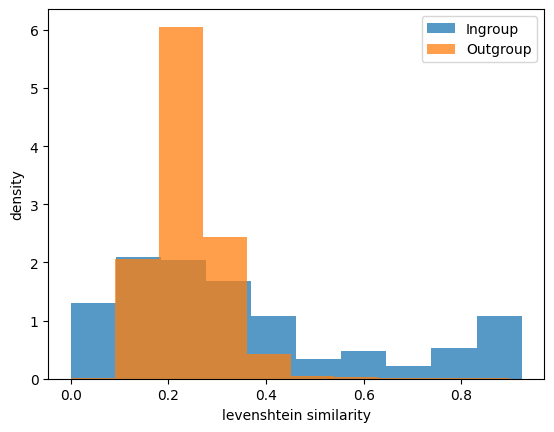

In [9]:
sim = 'levenshtein'
ingroup_lev, outgroup_lev = get_similarities(ingroup_pairs, outgroup_pairs, similarity=sim)
plt.hist(ingroup_lev, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_lev, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

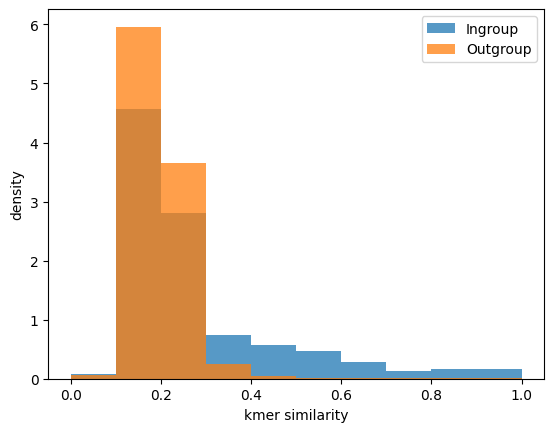

In [14]:
sim = 'kmer'
ingroup_kmer, outgroup_kmer = get_similarities(ingroup_pairs, outgroup_pairs, similarity=sim)
plt.hist(ingroup_kmer, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_kmer, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

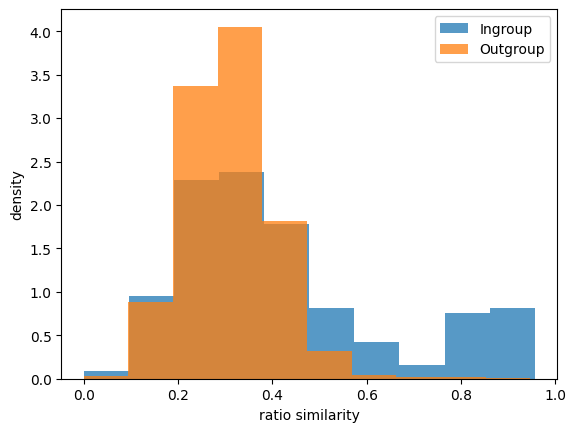

In [15]:
sim = 'ratio'
ingroup_ratio, outgroup_ratio = get_similarities(ingroup_pairs, outgroup_pairs, similarity=sim)
plt.hist(ingroup_ratio, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_ratio, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

## Evaluating Deep Learning Based Methods

In [7]:
#from transformers import EsmModel, EsmConfig

ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)

device='cuda' if torch.cuda.is_available() else 'cpu'
ESM2_MODEL.to(device)

EsmForMaskedLM(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

### Defining the ACE Neural Engine

In [8]:
class AceNeuralEngine(nn.Module):
    """
    ACE Neural Engine handles the contextual sequence encoding 
    of the different peptides to generate embeddings. Once the 
    model outputs are calculated the actual represetnation
    can be chosen from the following.

    Representation options:CDR3b
    - pooler_output: output of the pooler layer
    - cls_embedding: embedding of the [CLS] token
    - mean_pooling: mean pooling of the last hidden state
    - max_pooling: max pooling of the last hidden state

    Representation implementations are based on the HuggingFace Transformers library
    and code from this Kaggle Notebook: https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently
    """

    def __init__(self, base_model, tokenizer, device=None):
        super(AceNeuralEngine, self).__init__()
        self.model = base_model
        self.tokenizer = tokenizer
        self.device = device if device is not None else torch.device('cpu')
        self.model.to(self.device)

    def forward(self, inputs, representation='last_hidden_state'):
        """
        Implements the forward function of the nerural engine to get the output of the model
        before grabbing the embedding as the speccified representation.
        """
        
        # 1. Move the inputs to the correct device
        ### inputs: [batch_size, max_seq_len]
        if isinstance(inputs, list):
            inputs = self.tokenizer(inputs, padding=True, return_tensors='pt')
        inputs = inputs.to(self.device)
        attention_mask = inputs['attention_mask']
        model_outputs = self.model(**inputs)

        # 2. Get the correct transformer representation
        # representation: [batch_size, max_seq_len, hidden_size]
        if representation == 'last_hidden_state':    
            representation = model_outputs.hidden_states[-1]
        
        elif representation == 'pooler_output':
            if hasattr(model_outputs, 'pooler_output'):
                # repesentation: [batch_size, pooler_dim]
                representation = model_outputs.pooler_output
            else:
                raise ValueError("Base model does not have a pooler_output")
        
        elif representation == 'cls_embedding':
            # repesentation: [batch_size, hidden_size]
            representation = model_outputs.hidden_states[-1][:, 0, :]
    
        elif representation=='mean_pooling':
            # repesentation: [batch_size, hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            representation = model_outputs.hidden_states[-1].mean(dim=1)

        elif representation=='max_pooling':
            representation = torch.max(model_outputs.hidden_states[-1], 1)[0]
                
        elif representation == 'mean_max_pooling':
            # repesentation: [batch_size, 2*hidden_size]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(model_outputs.hidden_states[-1].size()).float()
            sum_embeddings = torch.sum(model_outputs.hidden_states[-1] * input_mask_expanded, 1)
            sum_mask = input_mask_expanded.sum(1)
            sum_mask = torch.clamp(sum_mask, min=1e-9)
            mean_embeddings = sum_embeddings / sum_mask
            max_embeddings = torch.max(model_outputs.hidden_states[-1], 1)[0]
            representation = torch.cat((mean_embeddings, max_embeddings), 1)
        
        elif representation == 'concatenate_pooling':
            # Strategy: concatenate the last four layers and then pool
            # Alternative strategies: concatenate the last two layers and then pool, 
            # intercalate different layers and pool, etc.

            # repesentation: [batch_size, num_final_layers*hidden_size] 
            queried_hidden_states = torch.stack(model_outputs.hidden_states[-4:])
            representation = torch.cat(tuple(queried_hidden_states), dim=-1)

        #TODO: implement other pooling strategies (e.g. weighted_layer_pooling, attention_pooling)
        # elif self.representation == 'weighted_layer_pooling':
        # elif self.representation == 'attention_pooling':
            
        return representation

    def load_weights(self, weights_path):
        """Load weights from a file"""
        self.load_state_dict(torch.load(weights_path, map_location=self.device))

    def save_weights(self, weights_path):
        """Save weights to a file"""
        torch.save(self.model.state_dict(), weights_path)

    def freeze(self):
        """Freeze the model"""
        for param in self.model.parameters():
            param.requires_grad = False

    def unfreeze(self):
        """Unfreeze the model"""
        for param in self.model.parameters():
            param.requires_grad = True

    @staticmethod
    def cosine_similarity(emb1, emb2):
        """Cosine similarity between two vectors"""
        a = emb1.reshape(-1)
        b = emb2.reshape(-1)
        return np.dot(a,b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

    @staticmethod
    def euclidean_similarity(emb1, emb2):
        """Euclidean similarity between two vectors"""
        a = emb1.reshape(-1)
        b = emb2.reshape(-1)
        return 1 - np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b))

    def embed_sequences(self, sequences, representation='last_hidden_state'):
        """Calculate embeddings for a list of sequences"""
        # Tokenize sequences
        tokenized = self.tokenizer(list(sequences), padding=True, return_tensors='pt')

        # Get embeddings
        with torch.no_grad():
            output = self.forward(tokenized, representation=representation)
            embeddings = output.cpu().numpy()

        assert len(embeddings) == len(sequences)
        return embeddings

    def find_paired_peptides(self, peptide_ids, peptide_sequences, representation='last_hidden_state', sim_fxn='euclidean', threshold=0.65):
        embeddings = self.embed_sequences(peptide_sequences, representation=representation)
        paired_peptide_ids = []
        for i in range(len(peptide_ids)):
            # For every peptide and every other peptide
            for j in range(len(peptide_ids)):
                if i == j:
                    continue
                if sim_fxn == 'euclidean':
                    metric =self.euclidean_similarity(embeddings[i], embeddings[j])
                    if metric >= threshold:
                        #if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        #    continue
                        #else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
                elif sim_fxn == 'cosine':
                    metric = self.cosine_similarity(embeddings[i], embeddings[j])
                    if metric >= threshold:
                        #if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        #    continue
                        #else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
                else:
                    raise ValueError("Similarity function must be 'euclidean' or 'cosine'")
        return list(paired_peptide_ids)
    
    def calculate_paired_distances(self, pair_list, representation='last_hidden_state', sim_fxn='euclidean'):
        distances = []
        for pair in pair_list:
            embeddings = self.embed_sequences(list(pair), representation=representation)
            if sim_fxn == 'euclidean':
                metric = self.euclidean_similarity(embeddings[0], embeddings[1])
                distances.append((pair, metric))
            elif sim_fxn == 'cosine':
                metric = self.cosine_similarity(embeddings[0], embeddings[1])
                distances.append((pair, metric))
            else:
                raise ValueError("Similarity function must be 'euclidean' or 'cosine'")
        return distances

    def find_levenshtein_paired_peptides(self, peptide_ids, peptide_sequences, threshold=1):
        paired_peptide_ids = []
        for i in range(len(peptide_ids)):
            for j in range(len(peptide_ids)):
                if i == j:
                    continue
                metric = levenshtein.distance(peptide_sequences[i], peptide_sequences[j])
                if metric <= threshold:
                    if (peptide_sequences[j], peptide_sequences[i], metric) in paired_peptide_ids:
                        continue
                    else:
                        paired_peptide_ids.append((peptide_sequences[i], peptide_sequences[j], metric))
        return list(paired_peptide_ids)
    
    @staticmethod
    def to_paired_peptide_df(paired_peptide_triples):
        """Convert a list of paired peptides to a dataframe"""
        return pd.DataFrame(paired_peptide_triples, columns=['peptide_id_1', 'peptide_id_2', 'similarity'])
    
ang_untrained = AceNeuralEngine(ESM2_MODEL, ESM2_TOKENIZER, device=device)

In [8]:
##################################################################################
##################### Embedding Utilities ########################################
##################################################################################

def embed_sequences(sequences, model, tokenizer):
    """Calculate embeddings for a list of sequences"""
    if isinstance(tokenizer, BertTokenizer):
        if isinstance(model, BertModel):
            sequences = [re.sub('', ' ', seq) for seq in sequences]
        else:
            raise ValueError("Model must be a BertModel")
    # Tokenize sequences
    tokenized = tokenizer(list(sequences), padding=True, return_tensors='pt')

    # Get embeddings
    with torch.no_grad():
        output = model(tokenized)
        embeddings = output.cpu().numpy()
    return embeddings

def cosine_similarity(emb1, emb2):
    """Cosine similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return np.dot(a,b.T)/(np.linalg.norm(a)*np.linalg.norm(b))

def euclidean_similarity(emb1, emb2):
    """Euclidean similarity between two vectors"""
    a = emb1.reshape(-1)
    b = emb2.reshape(-1)
    return 1 - np.linalg.norm(a-b)/(np.linalg.norm(a)+np.linalg.norm(b))

##################################################################################
##################### Bootstrapping Utilities ####################################
##################################################################################

def calculate_embedding_similarity(embeddings, similarity_fxn):
    """For all pairs of embeddings, calculate the similarity between them."""
    similarities = []
    for i in range(len(embeddings)):
        for j in range(i+1, len(embeddings)):
            embedding1 = embeddings[i]
            embedding2 = embeddings[j]
            similarities.append(similarity_fxn(embedding1, embedding2))
    return similarities

def get_embedding_similarities(ingroup_pairs, outgroup_pairs, model, tokenizer=ESM2_TOKENIZER, similarity='cosine'):
    """
    Calculate in/outgroup similarities for all CDR3b sequences in a dataframe
    """    
    ingroup_similarities = []
    outgroup_similarities = []
    
    # Embeddings for all ingroup/outgroup samples
    ingroup_similarities = [tup[1] for tup in model.calculate_paired_distances(ingroup_pairs, sim_fxn=similarity)]
    outgroup_similarities = [tup[1] for tup in model.calculate_paired_distances(outgroup_pairs, sim_fxn=similarity)]
    
    return ingroup_similarities, outgroup_similarities

### Pre-Trained (No Fine-Tuning)

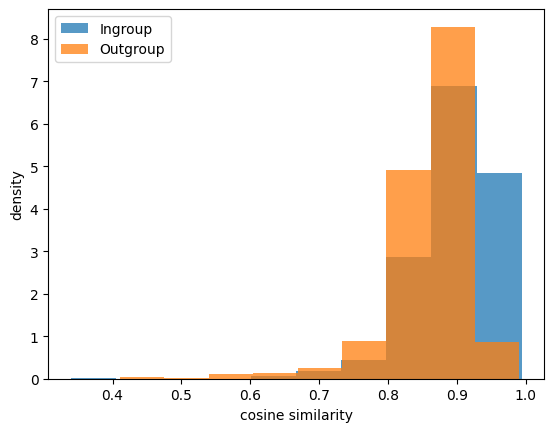

In [15]:
sim = 'cosine'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_pairs, outgroup_pairs, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
#plt.hist(ingroup_lev, alpha=0.95, density=True, color='#ADCDE2', label='Ingroup')
#plt.hist(outgroup_lev, alpha=0.95, density=True, color='#C7F497', label='Outgroup')
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

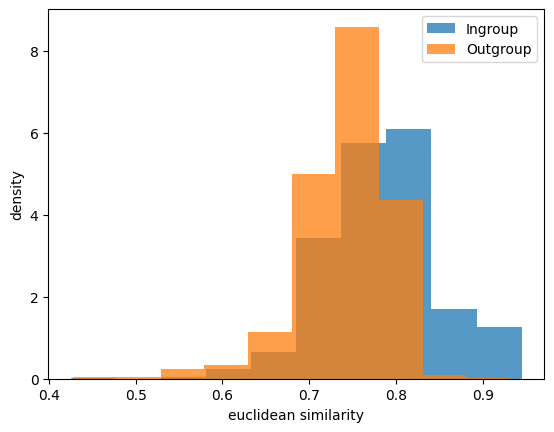

In [16]:
sim = 'euclidean'
ingroup_sims, outgroup_sims = get_embedding_similarities(ingroup_pairs, outgroup_pairs, model=ang_untrained, tokenizer=ESM2_TOKENIZER, similarity=sim)
#plt.hist(ingroup_lev, alpha=0.95, density=True, color='#ADCDE2', label='Ingroup')
#plt.hist(outgroup_lev, alpha=0.95, density=True, color='#C7F497', label='Outgroup')
plt.hist(ingroup_sims, alpha=0.75, density=True, label='Ingroup')
plt.hist(outgroup_sims, alpha=0.75, density=True, label='Outgroup')
plt.xlabel(f'{sim} similarity')
plt.ylabel('density')
plt.legend()
plt.show()

### Creating a Custom Dataset For Fine-Tuning 

In [10]:
def stratified_train_test_split(df, test_size=0.2, random_state=None):
    # Create a unique identifier for each combination of column_1 and column_2
    df['group_id'] = df['Epitope'].astype(str) + '_' + df['Allele'].astype(str) + '_' + df['Dataset.Origin'].astype(str)

    # Find the unique group_ids and their corresponding column_2 values
    groups = df[['group_id', 'Allele']].drop_duplicates()

    # Identify the groups that only have one instance
    group_counts = groups['Allele'].value_counts()
    singleton_groups = group_counts[group_counts == 1].index

    # Separate singleton groups and the rest
    singleton_df = groups[groups['Allele'].isin(singleton_groups)]
    groups = groups[~groups['Allele'].isin(singleton_groups)].sample(frac=1, random_state=random_state)

    # Stratified split on the groups
    train_groups, test_groups = train_test_split(groups, stratify=groups['Allele'], test_size=test_size, random_state=random_state)

    # Add the singleton groups to the train set
    train_groups = pd.concat([train_groups, singleton_df])

    # Use the group_ids to separate the original df
    train_df = df[df['group_id'].isin(train_groups['group_id'])]
    test_df = df[df['group_id'].isin(test_groups['group_id'])]

    # Drop the 'group_id' column we added for grouping
    train_df = train_df.drop(columns='group_id')
    test_df = test_df.drop(columns='group_id')

    # Drop epitopes from test that appear in train\
    #test_df = test_df[~test_df['Epitope'].isin(train_edf['Epitope'].unique())]
    test_df = pd.concat([test_df, train_df[train_df['Epitope'].isin(test_df['Epitope'].unique())]])
    train_df = train_df[~train_df['Epitope'].isin(test_df['Epitope'].unique())]
    #train_df = pd.concat([train_df, test_df[test_df['Epitope'].isin(train_epitopes)]])

    assert len(set(train_df['Epitope'].unique()).intersection(set(test_df['Epitope'].unique()))) == 0

    return train_df, test_df

In [11]:
train_df, test_df = stratified_train_test_split(data_df, test_size=0.10, random_state=42)
print(len(train_df['Epitope'].unique()), len(test_df['Epitope'].unique()))

453 67


In [ ]:
train_ingroup_peptides, train_outgroup_peptides = get_all_samples(train_df, strict_mode=False, n=100)
test_ingroup_peptides, test_outgroup_peptides = get_all_samples(test_df, strict_mode=False, n=100)

100%|██████████| 67/67 [00:00<00:00, 1196.62it/s]


In [ ]:
train_df_clean = train_df[train_df['Dataset.Origin'] != 'Negative']
test_df_clean = test_df[test_df['Dataset.Origin'] != 'Negative']
clean_ingroup_test, clean_outgroup_test = get_all_samples(test_df_clean, strict_mode=False, n=100)
clean_ingroup_train, clean_outgroup_train = get_all_samples(train_df_clean, strict_mode=False, n=100)

100%|██████████| 453/453 [00:09<00:00, 49.27it/s] 


In [12]:
train_dict = paired_df2dict(train_df)
test_dict = paired_df2dict(test_df)

def offline_triplet_mining(data_dict, balance_on_negatives=True):
    '''
    Offline Mining of Triplets:

    Instantiate a triplet 
    '''
    triplet_list = []
    max_positives = max([len(data_dict[epi]['positives']) for epi in data_dict.keys()])
    for epi in data_dict.keys():
        n_positives = len(data_dict[epi]['positives'])
        for pos in data_dict[epi]['positives']:
            if balance_on_negatives:
                for neg in data_dict[epi]['negatives'][:max(3, math.ceil(max_positives/n_positives))]:
                    triplet_list.append((epi, pos, neg))
            else:
                for neg in data_dict[epi]['negatives']:
                    if neg != pos:
                        triplet_list.append((epi, pos, neg))
    return triplet_list

train_triplets = offline_triplet_mining(train_dict)
test_triplets = offline_triplet_mining(test_dict)

In [11]:
class AceDataset2(torch.utils.data.Dataset):
    """
    Dataset class for ACE data. Designed to train
    the ACE Deep Learning Module for sequence
    dissimilarity prediction. Designed to be used
    as a PyTorch Dataset object for triplet loss.

    Args:
    data_dict: dictionary of epitopes and their corresponding positives and negatives
    """

    def __init__(self, data_dict, tokenizer, use_hard_negatives=False, online_mining=False, batched_sampling=False, max_len=15):
        self.data_dict = data_dict
        self.online_mining = online_mining
        self.batched_sampling = batched_sampling
        self.triplet_list = self.offline_triplet_mining(data_dict) if not online_mining else None
        self.tokenizer = tokenizer
        self.max_length = max_len
        self.use_hard_negatives = use_hard_negatives

    def __len__(self):
        if not self.online_mining:
            if self.batched_sampling:
                return len(self.data_dict.keys())
            return len(self.triplet_list)
        
    def __getitem__(self, idx):
        if not self.online_mining:
            if self.batched_sampling==True:
                anchor = list(self.data_dict.keys())[idx]
                pos = self.get_positive_example(anchor)
                neg = self.get_negative_example(anchor)
            else:
                anchor, pos, neg = self.triplet_list[idx]
            return anchor, pos, neg

    def get_positive_example(self, anchor):
        """
        Get a positive example for a given anchor epitope sequence.
        """
        positives = self.data_dict[anchor]['positives']
        if len(positives) == 0:
            return self.perturb_input(anchor, positive=True)
        coint_toss = np.random.uniform(0.0, 1.0, size=1)[0]
        if coint_toss < 0.35:
            # Return the one with the highest CDR3 overlap
            return positives[0]
        return random.choice(positives)
    
    def get_negative_example(self, anchor):
        """
        Get a negative example for a given anchor index.
        Here we define a negative example as a peptide
        with a different CDR3b sequence.
        """
        negatives = self.data_dict[anchor]['negatives']
        if len(negatives) == 0:
            return self.perturb_input(anchor, positive=False)
        coin_toss = np.random.uniform(0.0, 1.0, size=1)[0]
        if self.use_hard_negatives:
            # Return the one with the lowest CDR3 overlap
            if coin_toss < 0.35:
                return negatives[0]
        return random.choice(negatives)

    def perturb_input(self, anchor, positive=False):
        """
        Perturb the input sequence for a given anchor index.
        """
        if positive:
            # Change up a single amino acid in the epitope
            perturbed = self.perturb_peptide(anchor, 1)
        else:
            # Return a random epitope [can be the original]
            perturbed = self.perturb_peptide(anchor, 3)
        return perturbed
    
    def perturb_peptide(self, peptide, swaps=3):
        """
        Perturb a peptide sequence.
        """
        peptide = list(peptide)
        perturbed_peptide = peptide.copy()
        for _ in range(swaps):
            perturbed_peptide[random.randint(0, len(peptide)-1)] = random.choice(list('ACDEFGHIKLMNPQRSTVWY'))
        return ''.join(perturbed_peptide)
            
    def collate_fn(self, batch):
        """
        Processing a batch of data in the ACE Dataset.
        """
        bsz = len(batch)
        
        # Extract the data triple [(anchor, positive, triple)*bsz]
        anchors, positives, negatives = zip(*batch)
        if self.online_mining:
            return anchors, positives, negatives
            
        # Format the sequence for a BERT model if need be
        if isinstance(self.tokenizer, BertTokenizer):
            anchors = [re.sub('', ' ', anch) for anch in anchors]
            positives = [re.sub('', ' ', pos) for pos in positives]
            negatives = [re.sub('', ' ', neg) for neg in negatives]

        # Tokenize and Pad according to the max_length in the batch
        tokenized_anchors = self.tokenizer(anchors, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_positives = self.tokenizer(positives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')
        tokenized_negatives = self.tokenizer(negatives, max_length=self.max_length,padding='max_length', truncation=True, return_tensors='pt')

        return tokenized_anchors, tokenized_positives, tokenized_negatives

    def get_dataloader(self, batch_size, shuffle=False):
        """
        Call a dataloader object using the configurations of the current dataset.
        """
        #sampler = BalancedBatchSampler(self.triplet_list, batch_size=batch_size)
        dataloader = torch.utils.data.DataLoader(dataset=self, 
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            collate_fn=self.collate_fn,
                                            pin_memory=False,
                                            drop_last=False)
        return dataloader

    def offline_triplet_mining(self, balance_on_negatives=True):
        '''
        AceNeuralEngine
        '''
        triplet_list = []
        max_positives = max([len(self.data_dict[epi]['positives']) for epi in self.data_dict.keys()])
        for epi in self.data_dict.keys():
            n_positives = len(self.data_dict[epi]['positives'])
            for pos in self.data_dict[epi]['positives']:
                if balance_on_negatives:
                    for neg in self.data_dict[epi]['negatives'][:max(3, math.ceil(max_positives/n_positives))]:
                        triplet_list.append((epi, pos, neg))
                else:
                    for neg in self.data_dict[epi]['negatives']:
                        if neg != pos:
                            triplet_list.append((epi, pos, neg))
        return triplet_list


class BalancedBatchSampler(torch.utils.data.Sampler):
    def __init__(self, triplet_list, batch_size):
        self.triplet_list = triplet_list
        self.batch_size = batch_size
        self.num_triplets = len(self.triplet_list)

    def __iter__(self):
        # Shuffle triplets
        indices = list(range(self.num_triplets))
        np.random.shuffle(indices)

        for start_idx in range(0, self.num_triplets, self.batch_size):
            batch_indices = indices[start_idx:start_idx + self.batch_size]
            yield batch_indices

    def __len__(self):
        return self.num_triplets // self.batch_size


In [13]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.epsilon = 1e-8

    def forward(self, anchor, positive, negative):
        pos_dist = torch.sqrt(torch.sum((anchor - positive) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        neg_dist = torch.sqrt(torch.sum((anchor - negative) ** 2, dim=1) + self.epsilon)  # Euclidean distance
        loss = torch.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

# class TripletLoss(nn.Module):
#     def __init__(self, margin=0.2):
#         super(TripletLoss, self).__init__()
#         self.margin = margin

#     def forward(self, anchor, positive, negative):
#         pos_dist = torch.sum((anchor - positive) ** 2, dim=1)
#         neg_dist = torch.sum((anchor - negative) ** 2, dim=1)
#         loss = torch.relu(pos_dist - neg_dist + self.margin)
#         return loss.mean()

# Initialize your model and loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
_ESM2_TOKENIZER = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
_ESM2_MODEL = AutoModelForMaskedLM.from_pretrained("facebook/esm2_t6_8M_UR50D", return_dict=True, output_hidden_states=True)
model = AceNeuralEngine(_ESM2_MODEL, _ESM2_TOKENIZER, device=device).to(device)
loss_fn = TripletLoss(margin=1.0)

In [ ]:
### Get the train and test dataset and dataloader
USE_HARD_NEGATIVES=True

# Load the train data
train_dset = AceDataset2(train_dict, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, online_mining=False, batched_sampling=True, max_len=15)
train_loader = train_dset.get_dataloader(64, shuffle=True)
train_sample = next(iter(train_loader))

# Load the test data
test_dset = AceDataset2(test_dict, _ESM2_TOKENIZER, use_hard_negatives=USE_HARD_NEGATIVES, online_mining=False, batched_sampling=False, max_len=15)
test_loader = test_dset.get_dataloader(64, shuffle=False)
test_sample = next(iter(test_loader))

# Anchor, Positive, Negative
assert len(train_sample)==3
assert len(test_sample)==3

In [145]:
# Set up your optimizer
learning_rate = 1e-6
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

training_losses = []
val_losses = []

num_epochs = 3000
log_interval = 10
step = 0

# Training loop
for epoch in range(num_epochs):
    for batch in train_loader:
        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        anchor, positive, negative = batch
        anchor_emb = model(anchor)
        positive_emb = model(positive)
        negative_emb = model(negative)

        # Calculate the loss
        loss = loss_fn(anchor_emb, positive_emb, negative_emb)
        
        # Backward pass and optimization
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        step += 1

        # Update the adaptive margin
        # with torch.no_grad():
        #     margin_update = 0.1  # Define your own strategy for updating the margin
        #     loss_diff = distance_pos.mean() - distance_neg.mean()
        #     self.loss_fn.margin += margin_update * loss_diff.item()

        # Print the loss for monitoring
        if step % log_interval == 0:
            training_losses.append(loss.item())
            

            # Do validation
            with torch.no_grad():
                vlosses = []
                for batch in test_loader:
                    anchor, positive, negative = batch
                    anchor_emb = model(anchor)
                    positive_emb = model(positive)
                    negative_emb = model(negative)
                    vloss = loss_fn(anchor_emb, positive_emb, negative_emb)
                    vlosses.append(vloss.item())
                val_losses.append(np.mean(vlosses))
            
            print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item()}, Validation Loss: {np.mean(vlosses)}")


# Save the trained model
#torch.save(model.state_dict(), "trained_model.pt")

Epoch [2/3000], Train Loss: 0.8585993647575378, Validation Loss: 0.8939359982808431
Epoch [3/3000], Train Loss: 0.8033201098442078, Validation Loss: 0.8911999662717184
Epoch [4/3000], Train Loss: 0.8007554411888123, Validation Loss: 0.8883719046910604
Epoch [5/3000], Train Loss: 0.6597024202346802, Validation Loss: 0.8857088088989258
Epoch [7/3000], Train Loss: 0.753345787525177, Validation Loss: 0.8829271793365479
Epoch [8/3000], Train Loss: 0.8039842844009399, Validation Loss: 0.880726138750712
Epoch [9/3000], Train Loss: 0.7874845862388611, Validation Loss: 0.8789149721463522
Epoch [10/3000], Train Loss: 0.7023545503616333, Validation Loss: 0.8766790628433228
Epoch [12/3000], Train Loss: 0.7510900497436523, Validation Loss: 0.8740871548652649
Epoch [13/3000], Train Loss: 0.6718032360076904, Validation Loss: 0.8718405365943909
Epoch [14/3000], Train Loss: 0.7216081619262695, Validation Loss: 0.8706091245015463
Epoch [15/3000], Train Loss: 0.6495574712753296, Validation Loss: 0.870094

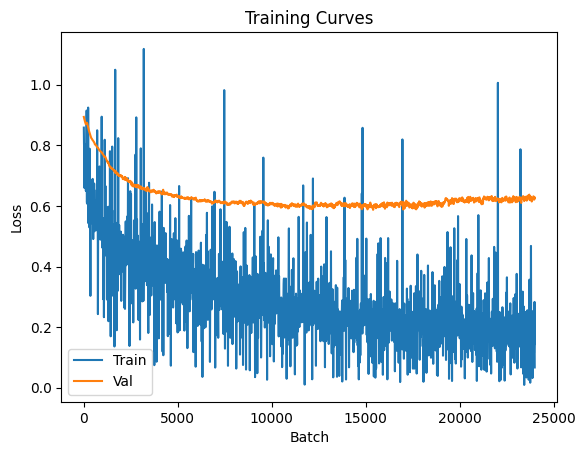

In [146]:
iters = np.arange(0, len(training_losses)*log_interval, log_interval)
plt.plot(iters, training_losses)
plt.plot(iters, val_losses)
plt.xlabel("Batch")
plt.title('Training Curves')
plt.ylabel("Loss")
#plt.ylim(0, 1)
plt.legend(['Train', 'Val'])
plt.show()

In [173]:
# history = pd.DataFrame()
# history['training_loss'] = training_losses
# history['validation_loss'] = val_losses
# history.to_csv('training_history_data.csv', index=False)

In [175]:
#torch.save(model.state_dict(), "trained_model_w_data_augmentation_b3000.pt")

### Load Model from Checkpoint

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load("model_snapshot/trained_model_w_data_augmentation_b3000.pt", map_location=device))

<All keys matched successfully>

In [16]:
positive_pairs = []
negative_pairs = []

test_dict = paired_df2dict(test_df)
dict = test_dict

for key in dict.keys():
    positives = dict[key]['positives']
    for positive in positives:
        if positive != key:
            positive_pairs.append((key, positive))
    negatives = dict[key]['negatives']
    for negative in negatives:
        negative_pairs.append((key, negative))
    
#positive_pairs = clean_ingroup_test
#negative_pairs = clean_outgroup_test

In [15]:
PROTBERT_TOKENIZER = AutoTokenizer.from_pretrained("rostlab/prot_bert", do_lower_case=False)
PROTBERT_MODEL = AutoModelForMaskedLM.from_pretrained("rostlab/prot_bert", return_dict=True, output_hidden_states=True)

ang_pb = AceNeuralEngine(PROTBERT_MODEL, PROTBERT_TOKENIZER, device='cpu')

positive_pairs = [(re.sub('', ' ', pair[0])[1:-1], re.sub('', ' ', pair[1])[1:-1]) for pair in positive_pairs]
negative_pairs = [(re.sub('', ' ', pair[0])[1:-1], re.sub('', ' ', pair[1])[1:-1]) for pair in negative_pairs]

protbert_positive_distances = [tup[1] for tup in ang_pb.calculate_paired_distances(positive_pairs)]
protbert_negative_distances = [tup[1] for tup in ang_pb.calculate_paired_distances(negative_pairs)]

#plt.hist(untrained_positive_distances, alpha=0.95, density=True, color='#ADCDE2', label='Ingroup')
#plt.histuntrainted_negative_distances, alpha=0.95, density=True, color='#C7F497', label='Outgroup')


Some weights of the model checkpoint at rostlab/prot_bert were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


KeyboardInterrupt: 

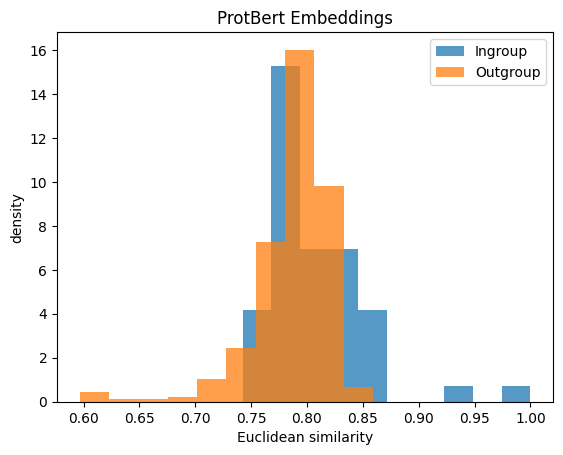

In [33]:
plt.hist(protbert_positive_distances, alpha=0.75, density=True, label='Ingroup')
plt.hist(protbert_negative_distances, alpha=0.75, density=True, label='Outgroup')
plt.xlabel('Euclidean similarity')
plt.ylabel('density')
plt.title('ProtBert Embeddings')
plt.legend()
plt.show()

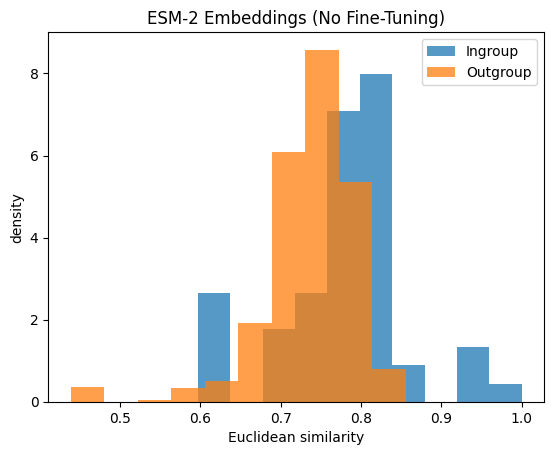

In [34]:
untrained_positive_distances = [tup[1] for tup in ang_untrained.calculate_paired_distances(positive_pairs)]
untrained_negative_distances = [tup[1] for tup in ang_untrained.calculate_paired_distances(negative_pairs)]

plt.hist(untrained_positive_distances, alpha=0.75, density=True, label='Ingroup')
plt.hist(untrained_negative_distances, alpha=0.75, density=True, label='Outgroup')
plt.xlabel('Euclidean similarity')
plt.ylabel('density')
plt.title('ESM-2 Embeddings (No Fine-Tuning)')
plt.legend()
plt.show()

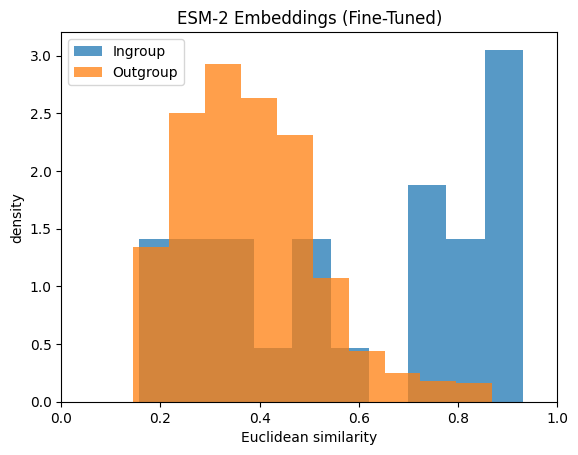

In [17]:
positive_distances = [tup[1] for tup in model.calculate_paired_distances(positive_pairs)]
negative_distances = [tup[1] for tup in model.calculate_paired_distances(negative_pairs)]

plt.hist(positive_distances, alpha=0.75, density=True, label='Ingroup')
plt.hist(negative_distances, alpha=0.75, density=True, label='Outgroup')
plt.xlabel('Euclidean similarity')
plt.ylabel('density')
plt.title('ESM-2 Embeddings (Fine-Tuned)')
plt.xlim(0, 1)
plt.legend()
plt.show()

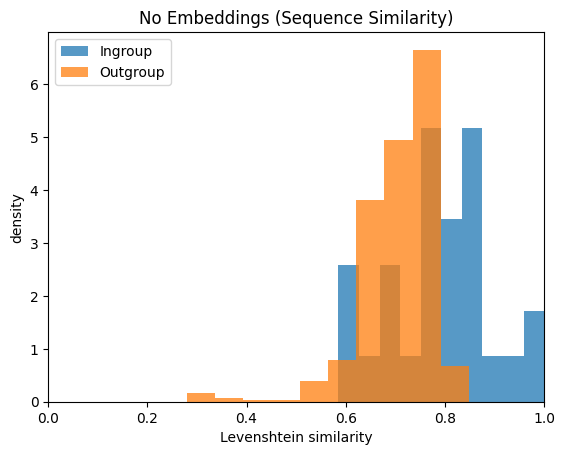

In [36]:
lev_positive_distances = [1 - levenshtein.distance(pair[0], pair[1])/max(len(pair[0]), len(pair[1])) for pair in positive_pairs]
lev_negative_distances = [1 - levenshtein.distance(pair[0], pair[1])/max(len(pair[0]), len(pair[1])) for pair in negative_pairs]

plt.hist(lev_positive_distances, alpha=0.75, density=True, label='Ingroup')
plt.hist(lev_negative_distances, alpha=0.75, density=True, label='Outgroup')
plt.xlabel('Levenshtein similarity')
plt.ylabel('density')
plt.title('No Embeddings (Sequence Similarity)')
plt.xlim(0, 1)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Euclidean Embedding vs. Levenshtein Similarity')

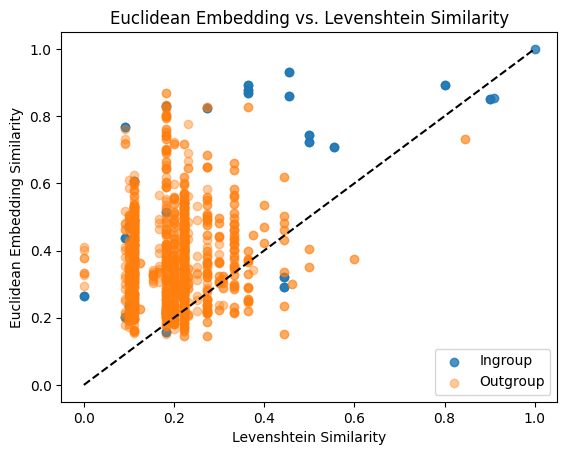

In [42]:
plt.scatter(lev_positive_distances, positive_distances, label='Ingroup', alpha=0.8)
plt.scatter(lev_negative_distances, negative_distances, label='Outgroup', alpha=0.4)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.legend(loc='lower right')
plt.ylabel('Euclidean Embedding Similarity')
plt.xlabel('Levenshtein Similarity')
plt.title('Euclidean Embedding vs. Levenshtein Similarity')

In [44]:
sample_df = test_df
#top10_cdr3bs = sample_df[sample_df['CDR3b'].isin(list(sample_df['CDR3b'].value_counts().index))].reset_index(drop=True)
sample_df['epitope2vec'] = sample_df['Epitope'].apply(lambda x: model.embed_sequences([x], representation='max_pooling')[0])

In [25]:
### Visualizing the Different Embeddings
data_df['epitope2vec'] = data_df['Epitope'].apply(lambda x: model.embed_sequences([x], representation='max_pooling')[0])

In [70]:
# Group by the epitope and count the number of CDR3b sequences per epitope
# Epitopes that bind many TCRs are interesting to see
temp_df = sample_df.groupby('Epitope').count().sort_values(by='CDR3b', ascending=False)
epitopes = list(temp_df[temp_df['CDR3b'] <= 1].index)

In [71]:
# Sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# This scales each column to have mean=0 and standard deviation=1
SS=StandardScaler()

# Apply scaling
query_df = test_df[test_df['Epitope'].isin(epitopes)]
data = np.stack(query_df['epitope2vec'])
scaled_data = SS.fit_transform(data)

components = 10
pca = PCA(n_components=components)
X_pca = pca.fit_transform(scaled_data)

# Convert to data frame
principal_df = pd.DataFrame(data = X_pca, columns = [f'PC{i}' for i in range(1, components+1)])
principal_df['Epitope'] = list(query_df['Epitope'])
principal_df['CDR3b'] = list(query_df['CDR3b'])
# Preview
principal_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,Epitope,CDR3b
0,-12.670787,-1.799027,4.885869,-4.609763,-0.902575,2.559532,-4.671283,-4.856934,-2.766498,6.194576,LLIRWQHFL,CASEGVHEQFF
1,-9.369802,5.448170,9.713480,-3.819091,4.194069,-3.960294,3.601445,-4.425351,6.367831,-1.188931,ILCETCLIV,CASSDLPGAPTDTQYF
2,1.220698,12.054482,-5.877788,-6.593600,-5.202689,-5.965000,1.655886,-0.005416,-1.008760,-1.114080,SLFNTIAVL,CASSDTVSYEQYF
3,-2.064494,13.417413,8.503078,10.160144,-2.631313,-6.250511,-4.679962,2.378868,-0.413729,2.310777,YLYDRLLRI,CASSLDQGAQDNEQFF
4,-6.127946,16.394247,-4.830033,6.504955,-2.234632,5.025196,7.266079,-5.373381,1.157959,0.598616,MTEYKLVVVGADGVGKSALTIQLI,CASSLGQTNYGYTF


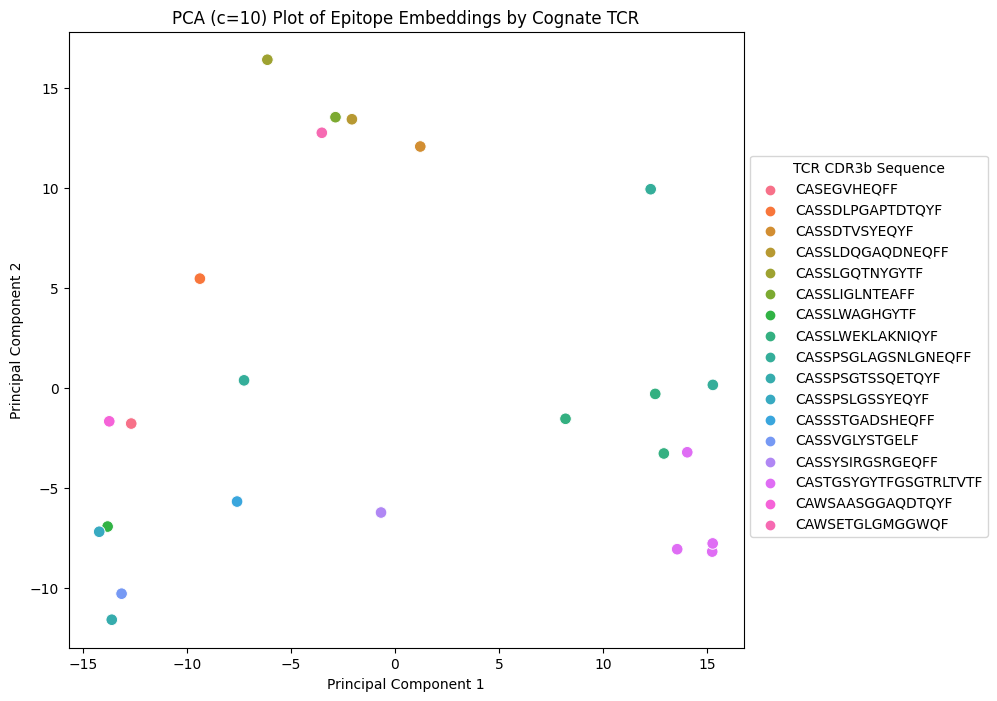

In [74]:
# Plot using seaborn for better coloring and legend
plt.figure(figsize=(10, 8))

# Choose a color palette for TCRs
palette = sns.color_palette("husl", n_colors=len(principal_df['CDR3b'].unique()))

# Scatter plot with color by TCR
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='CDR3b',
    data=principal_df,
    palette=palette,
    s=70  # Adjust the marker size as needed
)

# Add a legend outside the main figure
legend = plt.legend(title='TCR CDR3b Sequence', loc='upper left', bbox_to_anchor=(1, 0.81))

# Label axes and add a title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA (c=10) Plot of Epitope Embeddings by Cognate TCR')

# Adjust the plot layout to make space for the legend
plt.subplots_adjust(right=0.8)

# Show the plot
plt.show()

In [85]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=2)
X_tsne = tsne.fit_transform(scaled_data)


# Create a DataFrame
tsne_df = pd.DataFrame(data=X_tsne, columns = ['t-SNE Component 1', 't-SNE Component 2'])
tsne_df['Epitope'] = list(query_df['Epitope'])
tsne_df['CDR3b'] = list(query_df['CDR3b'])
tsne_df.head()

,t-SNE Component 1,t-SNE Component 2,Epitope,CDR3b
0,-109.317162,178.595779,LLIRWQHFL,CASEGVHEQFF
1,-94.042488,151.271896,ILCETCLIV,CASSDLPGAPTDTQYF
2,42.086262,19.570110,SLFNTIAVL,CASSDTVSYEQYF
3,-22.761005,64.481140,YLYDRLLRI,CASSLDQGAQDNEQFF
4,9.581323,-7.840864,MTEYKLVVVGADGVGKSALTIQLI,CASSLGQTNYGYTF


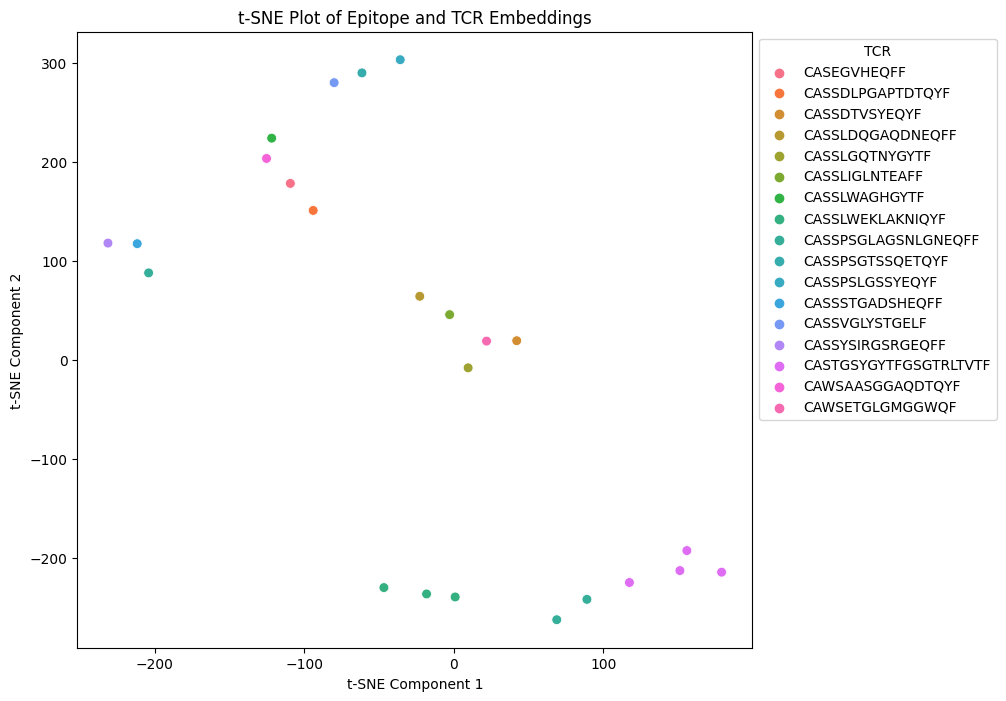

In [86]:

# Plot using seaborn for better coloring and legend
plt.figure(figsize=(10, 8))

# Choose a color palette for TCRs
palette = sns.color_palette("husl", n_colors=len(tsne_df['CDR3b'].unique()))

# Scatter plot with color by TCR
sns.scatterplot(
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='CDR3b',
    data=tsne_df,
    palette=palette,
    s=50  # Adjust the marker size as needed
)

# Add a legend outside the main figure
legend = plt.legend(title='TCR', loc='upper left', bbox_to_anchor=(1, 1))

# Label axes and add a title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Plot of Epitope and TCR Embeddings')

# Adjust the plot layout to make space for the legend
plt.subplots_adjust(right=0.8)

# Show the plot
plt.show()

/home/dxk/miniconda3/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


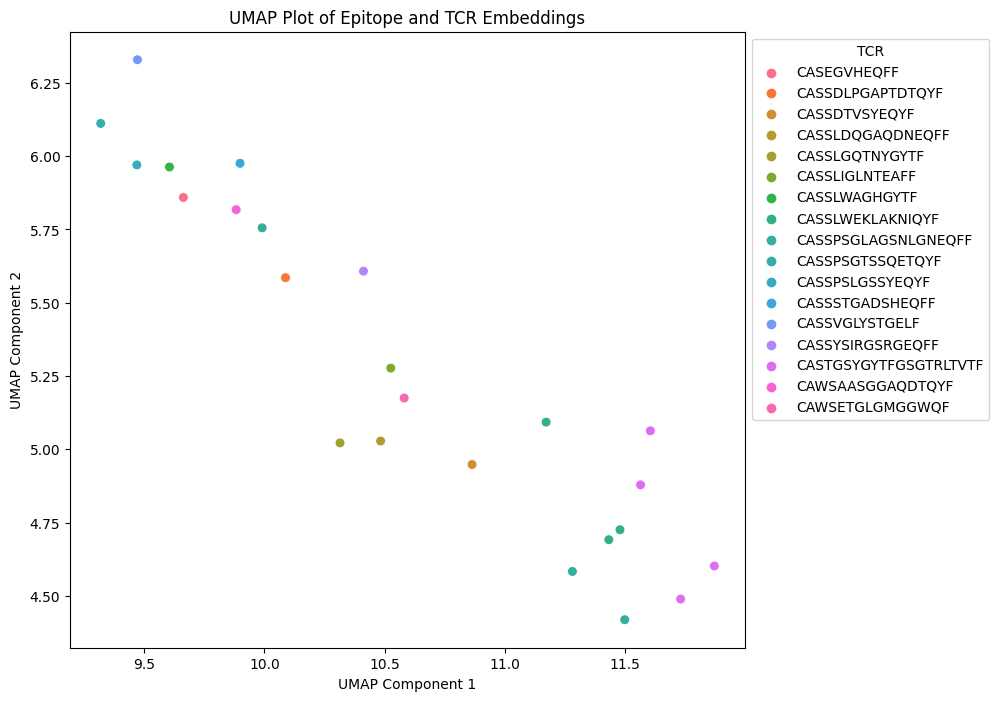

In [92]:
import umap

# Perform UMAP
umap_model = umap.UMAP(n_components=10, random_state=42)
X_umap = umap_model.fit_transform(scaled_data)

# Create a DataFrame
umap_df = pd.DataFrame(data=X_umap, columns=[f'UMAP Component {i}' for i in range(1, 11)])
umap_df['Epitope'] = list(query_df['Epitope'])
umap_df['CDR3b'] = list(query_df['CDR3b'])

# Plot using seaborn for better coloring and legend
plt.figure(figsize=(10, 8))

# Choose a color palette for TCRs
palette = sns.color_palette("husl", n_colors=len(umap_df['CDR3b'].unique()))

# Scatter plot with color by TCR
sns.scatterplot(
    x='UMAP Component 1',
    y='UMAP Component 2',
    hue='CDR3b',
    data=umap_df,
    palette=palette,
    s=50  # Adjust the marker size as needed
)

# Add a legend outside the main figure
legend = plt.legend(title='TCR', loc='upper left', bbox_to_anchor=(1, 1))

# Label axes and add a title
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Plot of Epitope and TCR Embeddings')

# Adjust the plot layout to make space for the legend
plt.subplots_adjust(right=0.8)

# Show the plot
plt.show()


In [176]:
# ingroup_euclidean_sims = pd.DataFrame()
# ingroup_euclidean_sims['ingroup_euclidean'] = untrained_positive_distances
# ingroup_euclidean_sims['fine_tuned_euclidean'] = positive_distances
# ingroup_euclidean_sims['levenshtein_euclidean'] = lev_positive_distances
# ingroup_euclidean_sims.to_csv('ingroup_euclidean_sims.csv', index=False)

In [177]:
# outgroup_euclidean_sims = pd.DataFrame()
# outgroup_euclidean_sims['outgroup_euclidean'] = untrained_negative_distances
# outgroup_euclidean_sims['finetuned_outgroup_euclidean'] = negative_distances
# outgroup_euclidean_sims['levenshtein_euclidean'] = lev_negative_distances
# outgroup_euclidean_sims.to_csv('outgroup_euclidean_sims.csv', index=False)

In [ ]:
#calculate confusion matrix
def get_confusion_matrix(ingroup_sims, outgroup_sims, threshold):
    """Calculate confusion matrix for a given threshold"""
    TP = sum(np.array(ingroup_sims) > threshold)
    FP = sum(np.array(outgroup_sims) > threshold)
    TN = sum(np.array(outgroup_sims) < threshold)
    FN = sum(np.array(ingroup_sims) < threshold)
    return np.array([[TP, FP], [FN, TN]])

def calculate_precision_recall(candidate_list, reference_list):
    def are_pairs_equal(pair1, pair2):
        # This helper function checks if two pairs are equal, regardless of the order of elements.
        return set(pair1) == set(pair2)

    TP = 0  # True Positives
    FP = 0  # False Positives
    FN = 0  # False Negatives

    for candidate_pair in candidate_list:
        found_match = False
        for reference_pair in reference_list:
            if are_pairs_equal(candidate_pair, reference_pair):
                TP += 1
                found_match = True
                break

        if not found_match:
            FP += 1

    for reference_pair in reference_list:
        found_match = False
        for candidate_pair in candidate_list:
            if are_pairs_equal(candidate_pair, reference_pair):
                found_match = True
                break

        if not found_match:
            FN += 1

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0.0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0.0
    return precision, recall


In [ ]:
cm = get_confusion_matrix(ingroup_euclidean, outgroup_euclidean, 0.65)
cm

NameError: name 'ingroup_euclidean' is not defined

In [ ]:
print(f'Precision:{cm[0,0]/(cm[0,0]+cm[0,1])}')

Precision:0.0035032530206620433


In [ ]:
print(f'Recall:{cm[0, 0]/(cm[0, 0]+cm[1, 0])}')

Recall:0.6901408450704225


### Alanine Scan Method (Peptide Length = 9)

In [110]:
test_dict = paired_df2dict(test_df)

In [154]:
p1 = random.choice(list(test_dict.keys()))
p_minus = random.sample(test_dict[p1]['negatives'], 10)
sample = [p1] + p_minus
sample


['QIKVRVKMV',
 'VQIISCQY',
 'YVLDHLIVV',
 'KIILFLPCI',
 'HLVEALYL',
 'YILKYSVFL',
 'ILCETCLIV',
 'RQWGPDPAAV',
 'FDVMVMPNL',
 'YLYDRLLRI',
 'ELRRKMMYM']

In [155]:
def alanine_scan(list_of_peptides):
    """
    Given the sampled peptide dataframe, perform an alanine scan
    
    Parameters
    ----------
    list_of_peptides : List[string]
    """
    
    # Get the alanine scan
    alanine_scan_seqs = []
    for original_peptide in list_of_peptides:
        for i in range(len(original_peptide)):
            alanine_peptide = original_peptide[:i] + 'A' + original_peptide[i+1:]
            alanine_scan_seqs.append(alanine_peptide)
    
    return alanine_scan_seqs

In [156]:
alanine_scan_seqs=alanine_scan(sample)
alanine_scan_seqs[:10]

['AIKVRVKMV',
 'QAKVRVKMV',
 'QIAVRVKMV',
 'QIKARVKMV',
 'QIKVAVKMV',
 'QIKVRAKMV',
 'QIKVRVAMV',
 'QIKVRVKAV',
 'QIKVRVKMA',
 'AQIISCQY']

In [157]:
def embed_sequences(sequences, model, tokenizer, representation='last_hidden_state'):
        """Calculate embeddings for a list of sequences"""
        # Tokenize sequences
        tokenized = tokenizer(list(sequences), padding=True, return_tensors='pt')

        # Get embeddings
        with torch.no_grad():
            output = model.forward(tokenized)[:,-1]
            embeddings = output.cpu().numpy()

        assert len(embeddings) == len(sequences)
        return embeddings

embedding_array = embed_sequences(alanine_scan_seqs, model, tokenizer=ESM2_TOKENIZER)
embedding_array.shape

(98, 320)

In [158]:
from scipy.spatial.distance import cdist
def generate_distance_heatmap(embeddings_array, distance_fxn='euclidean'):
    """
    Given a 2-D embeddings array. Generate a heatmap
    that displays the euclidean or cosine
    distance between each of the arrays.
    """
    distances = cdist(embeddings_array, embeddings_array, metric=distance_fxn)
    plt.imshow(distances)
    plt.colorbar()
    plt.show()

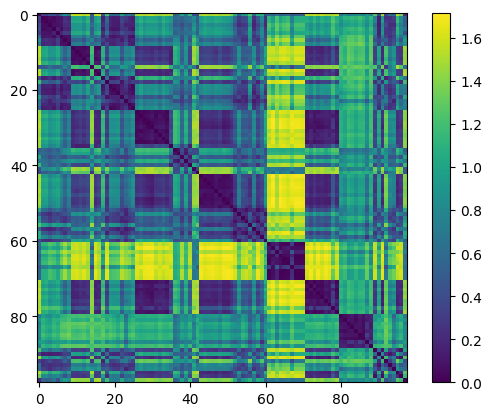

In [159]:
generate_distance_heatmap(embedding_array, 'cosine')

In [22]:
def compute_transitive_neighbors(
        peptide_pairs
):
    """
    Computes transitive peptide neighbors.

    Parameters
    ----------
    peptide_pairs       :   List of tuples (peptide ID, peptide ID).

    Returns
    -------
    peptide_neighbors   :   List of list of peptide IDs.
    """
    # Step 1. Create a dictionary to store peptide relationships
    peptide_dict = {}
    for peptide_id_1, peptide_id_2 in peptide_pairs:
        if peptide_id_1 not in peptide_dict:
            peptide_dict[peptide_id_1] = set()
        if peptide_id_2 not in peptide_dict:
            peptide_dict[peptide_id_2] = set()
        peptide_dict[peptide_id_1].add(peptide_id_2)
        peptide_dict[peptide_id_2].add(peptide_id_1)

    # Step 2. Find transitive peptide IDs
    transitive_peptides = []
    for peptide_id in peptide_dict:
        stack = list(peptide_dict[peptide_id])
        visited = set()
        while stack:
            curr_peptide_id = stack.pop()
            if curr_peptide_id not in visited:
                visited.add(curr_peptide_id)
                if curr_peptide_id in peptide_dict:
                    stack.extend(peptide_dict[curr_peptide_id])
        transitive_peptides.append(list(visited))

    # Step 3. De-duplicate peptide IDs
    transitive_peptides_ = []
    for i in transitive_peptides:
        duplicate = False
        for j in transitive_peptides_:
            if set(i) == j:
                duplicate = True
                break
        if not duplicate:
            transitive_peptides_.append(set(i))

    return [list(p) for p in transitive_peptides_]

def post_process(peptide_triples, top_k=1, return_dict=False):
    """
    Post-processes the peptide similarities. Create dictionary
    of peptide sequence to list of tuples sorted on similarity.

    
    """
    # Step 1. Create a dictionary to store peptide relationships
    peptide_dict = {}
    peptide_list = []

    for peptide_id_1, peptide_id_2, similarity in peptide_triples:
        if peptide_id_1 not in peptide_dict:
            peptide_dict[peptide_id_1] = []
        if peptide_id_2 not in peptide_dict:
            peptide_dict[peptide_id_2] = []
        peptide_dict[peptide_id_1].append((peptide_id_2, similarity))
        peptide_dict[peptide_id_2].append((peptide_id_1, similarity))

    # Step 2. Sort the peptide relationships and store top_k
    for peptide_id in peptide_dict:
        peptide_dict[peptide_id] = sorted(peptide_dict[peptide_id], key=lambda x: x[1], reverse=True)[:top_k]

    if return_dict:
        return peptide_dict
    else:
        for peptide_id in peptide_dict:
            for peptide_id_2, similarity in peptide_dict[peptide_id]:
                peptide_list.append((peptide_id, peptide_id_2))
        return peptide_list

In [59]:
sim_peps = model.find_paired_peptides(alanine_scan_seqs, alanine_scan_seqs, sim_fxn='euclidean', threshold=0.6)
compute_transitive_neighbors(post_process(sim_peps, 3))

[['RAHERNGFTVL',
  'ALTPAVVTL',
  'RHALPPYRVYL',
  'ALTPVVATL',
  'LLIAWQHFL',
  'LAIRWQHFL',
  'ALTPVVVTA',
  'ALTPVAVTL',
  'QAKVRVKMV',
  'LLIRWAHFL',
  'ALTAVVVTL',
  'ALTPVVVTL',
  'APHERNGFTVL',
  'AATPVVVTL',
  'LLARWQHFL',
  'LLIRWQHFA',
  'VAANAVLTV',
  'ALIRWQHFL',
  'RPHERNGFAVL'],
 ['RPHERNGATVL',
  'LLIRWQAFL',
  'RADLPPYRVYL',
  'ALLGIGILV',
  'RHDAPPYRVYL',
  'AAANIVLTV',
  'RPHERAGFTVL',
  'RPHERNGFTVA',
  'VAANIVLTA',
  'RPHEANGFTVL',
  'RPAERNGFTVL',
  'RHDLPPYAVYL',
  'RPHERNAFTVL',
  'RHDLPPYRVYA'],
 ['QIAVRVKMV', 'VAANIVLTV', 'QIKVAVKMV', 'AIKVRVKMV', 'LLIRWQHAL'],
 ['IPLTAEAEL',
  'IPLTEEAAL',
  'KASEKIFYA',
  'LLIRAQHFL',
  'KASEKAFYV',
  'YALKYSVFL',
  'YILKASVFL',
  'IALTEEAEL',
  'KAAEKIFYV',
  'YILKYSAFL',
  'KASEKIFYV',
  'IPLTEEAEA',
  'KASEKIFAV',
  'YILKYAVFL',
  'YILKYSVAL',
  'YIAKYSVFL',
  'IPATEEAEL',
  'AASEKIFYV',
  'AILKYSVFL',
  'KASAKIFYV',
  'KASEKIAYV',
  'YILAYSVFL',
  'QIKARVKMV',
  'IPLTEAAEL',
  'YILKYSVFA',
  'RPHARNGFTVL'],
 ['RHDLPPYRVAL

## Cross Reactivity Experiment

In [18]:
a = [
"ESDPIVAQY",
"EVDPIGHLY",
"EVDPIGHVY",
"EVDPIRHYY",
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
 ]


In [19]:
b = list(combinations(["ESDPIVAQY",
    "EVDPIGHLY",
    "EVDPIGHVY",
    "EVDPIRHYY"], 2))
c = list(combinations([
"EADPTGHSY",
"EVVPISHLY",
"EVDPTSNTY",
"EVDPAGHSY",
"EVDPTGHSF",
"EVDPTSHSY",
"EVVRIGHLY",
"EDNPSGHTY",
"KVNPNGHTY",
"KVDSTKDSY",
"EVNPTTHSY",
"EVNPTCHLY",
"EMDSSGESY",
"EVEPNKHIY",
"EVDPTTHCY",
"EMDPSRQSY",
"EVDPDDSYV",
"EVDPDDSYF",
"EVDPDDSYV",
"EVGPDHFCV",
"EVGPDHFCF",
"EVGPDHFCV",
"EVDPDHFYV",
"EVDPDHFYF",
"EVDPDHFYV",
"EIDKEEHLY",
"EIDKNDHLY",
"ELDPEAHTY",
"EVDTSEHIY",
"QFDRKHHTY",
"ELEPKSNTY",
"ELEPKSHSY",
"EIDTKNHAY" 
], 2))

tps = b + c

In [24]:
sim_peps = model.find_paired_peptides(a, a, sim_fxn='euclidean', threshold=0.7)
sim_peps[:20]

[('ESDPIVAQY', 'EVDPIRHYY', 0.7338911294937134),
 ('EVDPIGHLY', 'EVDPIGHVY', 0.8559621721506119),
 ('EVDPIGHLY', 'EVVPISHLY', 0.7249262928962708),
 ('EVDPIGHVY', 'EVDPIGHLY', 0.8559621721506119),
 ('EVDPIRHYY', 'ESDPIVAQY', 0.7338911294937134),
 ('EVDPIRHYY', 'EVEPNKHIY', 0.7413912415504456),
 ('EADPTGHSY', 'EVDPAGHSY', 0.7440119981765747),
 ('EVVPISHLY', 'EVDPIGHLY', 0.7249262928962708),
 ('EVDPTSNTY', 'EVDPTSHSY', 0.7655715644359589),
 ('EVDPTSNTY', 'EVEPNKHIY', 0.7311610579490662),
 ('EVDPTSNTY', 'EVDPTTHCY', 0.7482912540435791),
 ('EVDPTSNTY', 'EVDPDDSYF', 0.7289818525314331),
 ('EVDPTSNTY', 'EVDPDHFYF', 0.7184435427188873),
 ('EVDPTSNTY', 'EVDTSEHIY', 0.7057468891143799),
 ('EVDPAGHSY', 'EADPTGHSY', 0.7440119981765747),
 ('EVDPTGHSF', 'EVDPTSHSY', 0.7465244829654694),
 ('EVDPTSHSY', 'EVDPTSNTY', 0.7655715644359589),
 ('EVDPTSHSY', 'EVDPTGHSF', 0.7465244829654694),
 ('EVDPTSHSY', 'EVDPTTHCY', 0.7325735092163086),
 ('EVEPNKHIY', 'EVDPIRHYY', 0.7413912415504456)]

In [25]:
compute_transitive_neighbors(post_process(sim_peps, 1))

[['EVDPIRHYY',
  'ESDPIVAQY',
  'EIDKNDHLY',
  'EVDTSEHIY',
  'EVEPNKHIY',
  'EIDKEEHLY'],
 ['EVDPIGHLY', 'EVVPISHLY', 'EVDPIGHVY'],
 ['EVDPAGHSY', 'EADPTGHSY'],
 ['EIDTKNHAY',
  'EVDPTTHCY',
  'EVDPTSHSY',
  'EVDPTSNTY',
  'EVDPTGHSF',
  'ELDPEAHTY'],
 ['EVDPDDSYV', 'EVDPDDSYF'],
 ['EVDPDHFYF', 'EVDPDHFYV'],
 ['EVGPDHFCF', 'EVGPDHFCV']]

In [52]:
calculate_precision_recall(sim_peps, tps)

TP:  32
FP:  2


In [54]:
len(set(b).intersection(set([(p1,p2) for p1, p2, _ in sim_peps])))/len(set(b))

0.6666666666666666

## Aditional Papers

In [37]:
df = pd.read_csv('rojas_et_al_nature_2023.csv')
sim_peps = model.find_paired_peptides(df['Epitope'], df['Epitope'], sim_fxn='euclidean', threshold=0.8)
compute_transitive_neighbors(post_process(sim_peps, 2))

[['KAPETIPITPV',
  'SPGSVGVISPY',
  'MVSLGNSFLHK',
  'RMVQSHLAAGK',
  'ITVNASRPQPF',
  'GYPPPVAPSRL',
  'DRHSLSSADNL',
  'LEATGQARPPA',
  'FRGNLAGLTLC',
  'EEMPPFPERESF',
  'SNLRFENWFRR'],
 ['RVKDTDWKELY', 'NVFKLKTAAWR', 'EEQKADFPAGI', 'VTSRLTSGLVK'],
 ['TEYKLVVVGAV', 'TEYKLVVVGAC'],
 ['QARACQRVVVM'],
 ['FNKEHEFI'],
 ['VVVGADGVGK'],
 ['AETIGRHVLGI', 'ARLLISQAMGL'],
 ['TRYLGSRLVKL', 'PREVLSRLREL'],
 ['LYKAGARVKIM'],
 ['WPVRLTLSPL', 'AEEAATRANA', 'HTDESLGDCA'],
 ['SRKQNHLPKL']]

In [25]:
clusters = compute_transitive_neighbors(post_process(sim_peps, 2))
flatted_clusters = [item for sublist in clusters for item in sublist]
set(flatted_clusters).intersection(set(df[df['Binding']==1]['Epitope']))

set()

In [24]:
df[df['Binding']==1]

,HLA_Restriction,Epitope,Position,Protein,Score_EL,Percent_Rank_EL,Predicted_Binding_Level,Binding
0,A*02:01,YLQPRTFLL,269,Spike,0.972695,0.013,SB,1
2,A*02:01,TLDSKTQSL,109,Spike,0.912308,0.047,SB,1
59,A*02:01,LLLDRLNQL,222,Nucleocapsid,0.951445,0.024,SB,1
71,B*07:02,SPRWYFYYL,105,Nucleocapsid,0.789410,0.139,SB,1


## COVID Sliding Window 

In [26]:
spike_receptor_df = pd.read_csv("../data/spike_protein_receptor_export.csv")
spike_assay_df = pd.read_csv("../data/spike_protein_assay_export.csv")

/tmp/ipykernel_15503/466346193.py:1: DtypeWarning: Columns (11,12,14,15,18,19,20,21,22,23,29,35,44,48,49,50,58,64) have mixed types. Specify dtype option on import or set low_memory=False.
  spike_receptor_df = pd.read_csv("../data/spike_protein_receptor_export.csv")


In [27]:
pattern = re.compile(r'sars[\W_]*cov[\W_]*2', re.IGNORECASE)
spike_receptor_df = spike_receptor_df[spike_receptor_df['Epitope - Source Organism'].str.contains(pattern, na=False)]
spike_sequence = "MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFS \
                NVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIV \
                NNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLE \
                GKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQT \
                LLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETK \
                CTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISN \
                CVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIAD \
                YNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPC \
                NGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVN \
                FNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITP \
                GTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSY \
                ECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTI \
                SVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQE \
                VFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDC \
                LGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAM \
                QMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALN \
                TLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGRLQSLQTYVTQQLIRAAEIRA \
                SANLAATKMSECVLGQSKRVDFCGKGYHLMSFPQSAPHGVVFLHVTYVPAQEKNFTTAPA \
                ICHDGKAHFPREGVFVSNGTHWFVTQRNFYEPQIITTDNTFVSGNCDVVIGIVNNTVYDP \
                LQPELDSFKEELDKYFKNHTSPDVDLGDISGINASVVNIQKEIDRLNEVAKNLNESLIDL \
                QELGKYEQYIKWPWYIWLGFIAGLIAIVMVTIMLCCMTSCCSCLKGCCSCGSCCKFDEDD \
                SEPVLKGVKLHYT"
spike_sequence = spike_sequence.replace(" ", "")
spike_receptor_df = spike_receptor_df.iloc[[idx for idx, epitope in enumerate(spike_receptor_df['Epitope - Name']) if epitope in spike_sequence]]
spike_receptor_df = spike_receptor_df.reset_index(drop=True)

In [28]:
subset_receptor_df = spike_receptor_df[['Epitope - Name', 'Chain 2 - CDR3 Curated']].drop_duplicates()
subset_receptor_df['count'] = subset_receptor_df.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
#spike_receptor_df[['Epitope - Name', 'Chain 2 - CDR3 Curated']].drop_duplicates()['count'] = spike_receptor_df.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
subset_receptor_df[subset_receptor_df['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)

,Epitope - Name,Chain 2 - CDR3 Curated,count
8310,FPQSAPHGVVF,CASSQGYEQYF,3.0
8311,VLPFNDGVYFASTEK,CASSQGYEQYF,3.0
8312,VQPTESIVRFPNITNLCPF,CASSQGYEQYF,3.0
7126,YYVGYLQPRTFLL,CASSPLAGGNTGELFF,3.0
7127,APHGVVFLHVTYV,CASSPLAGGNTGELFF,3.0
...,...,...,...
14680,YLQPRTFLL,CAMQEMNTGELFF,2.0
195,YYVGYLQPRTFLL,CAIQEANTGELFF,2.0
15516,YLQPRTFLL,CAIQEANTGELFF,2.0
193,YYVGYLQPRTFLL,CAIQDLNTGELFF,2.0


In [6]:
#len(subset_receptor_df[subset_receptor_df['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)['Epitope - Name'].unique())
niners = subset_receptor_df[subset_receptor_df['Epitope - Name'].str.len() == 9]
niners['count'] = niners.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')
niners[niners['count'] > 1].sort_values(by=['count', 'Chain 2 - CDR3 Curated'], ascending=False)

/tmp/ipykernel_6156/3810866050.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  niners['count'] = niners.groupby('Chain 2 - CDR3 Curated')['Chain 2 - CDR3 Curated'].transform('count')


,Epitope - Name,Chain 2 - CDR3 Curated,count
6278,TPINLVRDL,CASSPGTGSYEQYF,2.0
6279,NLNESLIDL,CASSPGTGSYEQYF,2.0
6309,NLNESLIDL,CASSPGTGGFYEQYF,2.0
6310,TPINLVRDL,CASSPGTGGFYEQYF,2.0
6332,RLFRKSNLK,CASSPGQGAYEQYF,2.0
6333,NLNESLIDL,CASSPGQGAYEQYF,2.0
5656,LPPAYTNSF,CASSLVGQPQHF,2.0
5657,RISNCVADY,CASSLVGQPQHF,2.0
4529,LEPLVDLPI,CASSLGTNYEQYF,2.0
4530,NLNESLIDL,CASSLGTNYEQYF,2.0


In [59]:
mira_full = pd.read_csv('../data/preprocessed_mira.csv')
mira_full = mira_full[['Epitope', 'CDR3b', 'ORF Coverage', 'TCR BioIdentity']]
mira_full = mira_full[mira_full['CDR3b']!='CunproductiveF']
mira_full = mira_full.drop_duplicates()
mira_subset = mira_full[mira_full['ORF Coverage'].str.contains('surface glycoprotein')]
mira_subset = mira_subset.reset_index(drop=True)
mira_subset['K-mer'] = [len(mira_subset['Epitope'][i]) for i in range(len(mira_subset))]
mira_subset[mira_subset['K-mer']==9]['CDR3b'].value_counts()


/tmp/ipykernel_10276/1447270349.py:1: DtypeWarning: Columns (30,31,32,33,34,35) have mixed types. Specify dtype option on import or set low_memory=False.
  mira_full = pd.read_csv('../data/preprocessed_mira.csv')


CASSPGQGYEQYF       16
CASSEGQGYEQYF       14
CASSLSQGYEQYF       13
CASSLGQGYEQYF       12
CASSLGVNTEAFF        9
                    ..
CASSHGHTPNWIQYF      1
CASSLDLSTGELFF       1
CASSSGDGANVLTF       1
CASKELAGVPGELFF      1
CASSQHSGGSYNEQFF     1
Name: CDR3b, Length: 18678, dtype: int64

In [60]:
mira_subset[mira_subset['K-mer']==9]

,Epitope,CDR3b,ORF Coverage,TCR BioIdentity,K-mer
0,ADAGFIKQY,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
3,TLADAGFIK,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
4,ADAGFIKQY,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
7,TLADAGFIK,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
8,ADAGFIKQY,CASSLWASGRGGTGELFF,"ORF1ab,surface glycoprotein",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,9
...,...,...,...,...,...
70677,NSIAIPTNF,CASASGGTEAFF,surface glycoprotein,CASASGGTEAFF+TCRBV19-01+TCRBJ01-01,9
70678,NQKLIANQF,CASSLEDLLYGYTF,surface glycoprotein,CASSLEDLLYGYTF+TCRBV07-02+TCRBJ01-02,9
70679,NQKLIANQF,CSAVRDRGYTEAFF,surface glycoprotein,CSAVRDRGYTEAFF+TCRBV20-X+TCRBJ01-01,9
70682,GVVFLHVTY,CASSPRVAGGPYEQYF,surface glycoprotein,CASSPRVAGGPYEQYF+TCRBV12-X+TCRBJ02-07,9


In [29]:
def tiling_window(input_string, k):
    tiles = []
    n = len(input_string)
    
    for i in range(n - k + 1):
        tile = input_string[i:i+k]
        tiles.append(tile)
    
    return tiles
    
tiling_9mers = np.unique(tiling_window(spike_sequence, 9))

In [62]:
mira_spike9 = mira_subset[mira_subset['K-mer']==9]
mira_spike9[mira_spike9['Epitope'].isin(tiling_9mers)]

,Epitope,CDR3b,ORF Coverage,TCR BioIdentity,K-mer
0,ADAGFIKQY,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
3,TLADAGFIK,CASSAQGTGDRGYTF,"ORF1ab,surface glycoprotein",CASSAQGTGDRGYTF+TCRBV27-01+TCRBJ01-02,9
4,ADAGFIKQY,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
7,TLADAGFIK,CASSKGTVSGLSGF,"ORF1ab,surface glycoprotein",CASSKGTVSGLSG+TCRBV21-01+TCRBJ02-07,9
8,ADAGFIKQY,CASSLWASGRGGTGELFF,"ORF1ab,surface glycoprotein",CASSLWASGRGGTGELFF+TCRBV27-01+TCRBJ02-02,9
...,...,...,...,...,...
70677,NSIAIPTNF,CASASGGTEAFF,surface glycoprotein,CASASGGTEAFF+TCRBV19-01+TCRBJ01-01,9
70678,NQKLIANQF,CASSLEDLLYGYTF,surface glycoprotein,CASSLEDLLYGYTF+TCRBV07-02+TCRBJ01-02,9
70679,NQKLIANQF,CSAVRDRGYTEAFF,surface glycoprotein,CSAVRDRGYTEAFF+TCRBV20-X+TCRBJ01-01,9
70682,GVVFLHVTY,CASSPRVAGGPYEQYF,surface glycoprotein,CASSPRVAGGPYEQYF+TCRBV12-X+TCRBJ02-07,9


In [ ]:
related_epitopes = []
for cdr3b in mira_subset['CDR3b'].unique():
    cdr3b_table = mira_subset[mira_subset['CDR3b'] == cdr3b]
    if len(cdr3b_table['Epitope'].unique()) == 1:
        continue
    else:
        related_epitopes += list(combinations(cdr3b_table['Epitope'].unique(), 2))
related_epitopes = list(set(related_epitopes))
#related_epitopes

In [168]:
print(len(related_epitopes))

def remove_reversed_tuples(lst):
    # Check if the list contains only tuples
    if not all(isinstance(item, tuple) for item in lst):
        return None
    
    # Convert the list to a set of tuples
    set_of_tuples = set(lst)
    
    # Initialize a new list to store the filtered tuples
    filtered_list = []
    
    # Check if the reversed tuple is in the set, and add to the filtered list if not
    for tpl in lst:
        reversed_tpl = tuple(reversed(tpl))
        if reversed_tpl not in set_of_tuples:
            filtered_list.append(tpl)
    
    return filtered_list

related_epitopes = remove_reversed_tuples(related_epitopes)
print(len(related_epitopes))

2312


In [63]:
all_queries = list(set(tiling_9mers).union(set(mira_spike9['Epitope'])))
positive_queries = list(mira_spike9['Epitope'].unique())

In [73]:
pred_related_peptides = model.find_paired_peptides(all_queries, all_queries, sim_fxn='euclidean', threshold=0.8)
#pred_levenshtein_peptides = neuro.find_levenshtein_paired_peptides(all_queries, all_queries, threshold=7)
#pred_levenshtein_peptides = [(s1, s2) for s1, s2, sim in pred_levenshtein_peptides if s1 != s2]
#$pred_related_peptides = [(s1, s2) for s1, s2, _ in pred_related_peptides if s1 != s2]
spike_groups = compute_transitive_neighbors(post_process(pred_related_peptides))

In [27]:
assert [item in spike_sequence for item in list(nonamers.values())]
assert [item in tiling_9mers for item in list(nonamers.keys())]

### Checking to See if Clustering Embeddings Works Well

In [117]:
from sklearn.cluster import KMeans, AgglomerativeClustering

def cluster_embeddings(batched_tensor, num_clusters=None, cluster_size=None, method='kmeans'):
    batched_tensor = batched_tensor.detach().cpu().numpy()
    n_points = batched_tensor.shape[0]
    
    if num_clusters is not None and num_clusters > n_points:
        num_clusters = n_points  # Each point is a separate cluster

    if cluster_size is not None and cluster_size > n_points:
        cluster_size = n_points  # All points in a single cluster

    if num_clusters is not None:
        n_clusters = num_clusters
    elif cluster_size is not None:
        n_clusters = n_points // cluster_size
    else:
        raise ValueError("You must specify at least one of 'num_clusters' or 'cluster_size'")

    matrix = batched_tensor.reshape(n_points, -1)  # Reshape the tensor into a 2-D matrix

    if method == 'kmeans':
        model = KMeans(n_clusters=n_clusters)
    elif method == 'agglomerative':
        model = AgglomerativeClustering(n_clusters=n_clusters)
    else:
        raise ValueError("'method' must be 'kmeans' or 'agglomerative'")

    model.fit(matrix)
    return model.labels_

In [58]:
sampled_cdr3bs = np.random.choice(data_df2['CDR3b'].unique(), size=10, replace=False)
sample_df = data_df2[data_df2['CDR3b'].isin(sampled_cdr3bs)]
sample_df

,CDR3b,Epitope,Allele
430,CASSPVVGGTGELFF,IMNDMPIYM,HLA-A*02:01
485,CASSPVVGGTGELFF,FLCMKALLL,HLA-A*02:01
490,CSAEGNTEAFF,FLCMKALLL,HLA-A*02:01
1047,CASSQETIAKNIQYF,VTEHDTLLY,HLA-A*01:01
1048,CASSQETIAKNIQYF,TPRVTGGGAM,HLA-B*07:02
1049,CASSQETIAKNIQYF,LPRRSGAAGA,HLA-B*07:02
1628,CAWKASGNTIYF,LPRRSGAAGA,HLA-B*07:02
1629,CAWKASGNTIYF,TPRVTGGGAM,HLA-B*07:02
4008,CASSYTNNSPLHF,TPRVTGGGAM,HLA-B*07:02
4009,CASSYTNNSPLHF,LPRRSGAAGA,HLA-B*07:02


In [80]:
embeddings = model(list(all_queries), representation='last_hidden_state')

OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB (GPU 0; 7.79 GiB total capacity; 6.40 GiB already allocated; 21.94 MiB free; 6.68 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [76]:
agg_cluster_labels = cluster_embeddings(embeddings, num_clusters=10, method='agglomerative')
kmeans_cluster_labels = cluster_embeddings(embeddings, num_clusters=10, method='kmeans')

/home/dxk/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [77]:
from sklearn.metrics import silhouette_score
silhouette_score(embeddings.detach().cpu().numpy(), agg_cluster_labels)

0.1187405

In [78]:
silhouette_score(embeddings.detach().cpu().numpy(), kmeans_cluster_labels)

0.12958853